In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/aryanb/aryan personal/code/datathon26/rl/data/data_v3_max_72_h.csv")  # your dataset
df["measure_time"] = pd.to_numeric(df["measure_time"], errors="coerce")
df = df.dropna(subset=["visit_occurrence_id", "measure_time"]).copy()
df = df.sort_values(["visit_occurrence_id", "measure_time"]).reset_index(drop=True)

# ---- carry-forward (LOCF) ----
VENT = ["peep_median", "peak_median"]
PHYS = ["map_median","sbp_median","dbp_median","temp_median",
        "wbc_median","hemoglobin_median","platelets_median",
        "sodium_median","potassium_median","chloride_median",
        "glucose_median","bun_median","creatinine_median","crp_median"]
VENT = [c for c in VENT if c in df.columns]
PHYS = [c for c in PHYS if c in df.columns]

for c in VENT + PHYS:
    df[f"{c}_missing"] = df[c].isna().astype(int)

# physiology: forward fill within visit
df[PHYS] = df.groupby("visit_occurrence_id")[PHYS].ffill()

# vent: (option 1) forward fill too, but keep missingness flags so model can learn
df[VENT] = df.groupby("visit_occurrence_id")[VENT].ffill()

# ---- build dp + transitions ----
df["dp_dyn"] = df["peak_median"] - df["peep_median"]

# action: PEEP bin or delta-PEEP (we'll do delta bins)
df["peep_t"] = df["peep_median"]
df["delta_peep"] = df.groupby("visit_occurrence_id")["peep_t"].diff()

# next-step labels
df["dp_dyn_next"] = df.groupby("visit_occurrence_id")["dp_dyn"].shift(-1)
df["map_next"] = df.groupby("visit_occurrence_id")["map_median"].shift(-1) if "map_median" in df.columns else np.nan

# terminal: last hour in each visit
df["is_terminal"] = df.groupby("visit_occurrence_id")["measure_time"].transform(lambda x: x == x.max()).astype(int)

# keep usable rows
rl = df[df["peep_t"].notna() & df["dp_dyn_next"].notna()].copy()
rl.reset_index(drop=True, inplace=True)

print("RL rows:", len(rl))
rl.head()


RL rows: 342510


,visit_occurrence_id,measure_time,person_id,gender,year_of_birth,visit_start_datetime,visit_end_datetime,visit_type_concept_name,admitted_from,discharged_to,...,chloride_median_missing,glucose_median_missing,creatinine_median_missing,crp_median_missing,dp_dyn,peep_t,delta_peep,dp_dyn_next,map_next,is_terminal
0,1,-1,6656,MALE,1942,2017-01-01 00:00:00+00:00,2017-01-18 08:52:00+00:00,EHR encounter record,No matching concept,No matching concept,...,1,1,1,1,32.00,8.00,NaN,32.15,69.0,0
1,1,0,6656,MALE,1942,2017-01-01 00:00:00+00:00,2017-01-18 08:52:00+00:00,EHR encounter record,No matching concept,No matching concept,...,1,1,0,0,32.15,7.85,-0.15,32.05,71.0,0
2,1,1,6656,MALE,1942,2017-01-01 00:00:00+00:00,2017-01-18 08:52:00+00:00,EHR encounter record,No matching concept,No matching concept,...,1,1,1,1,32.05,7.95,0.10,32.05,71.0,0
3,1,2,6656,MALE,1942,2017-01-01 00:00:00+00:00,2017-01-18 08:52:00+00:00,EHR encounter record,No matching concept,No matching concept,...,1,1,1,1,32.05,7.95,0.00,32.00,75.0,0
4,1,3,6656,MALE,1942,2017-01-01 00:00:00+00:00,2017-01-18 08:52:00+00:00,EHR encounter record,No matching concept,No matching concept,...,1,1,1,1,32.00,8.00,0.05,34.95,78.0,0


# Offline RL training (rewritten, consistent with `data_v3_max_72_h.csv`)

This notebook assumes the **first cell** built a dataframe named `rl` with at least:

- `visit_occurrence_id` (group id)
- `measure_time` (time ordering)
- `peep_t` (PEEP at time t)
- `delta_peep` (action taken by clinician at time t)
- `dp_dyn_next` (next-step driving pressure proxy)

If your first cell outputs `RL rows: ...` then you're good.

> Research only. Not for clinical use.


In [2]:

# =========================
# Cell 1 — Setup
# =========================
%pip -q install numpy pandas scikit-learn torch matplotlib joblib

import os, json, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

assert "rl" in globals(), "First cell should create a dataframe named `rl`."
print("rl shape:", rl.shape)
print("Columns (sample):", list(rl.columns)[:30])


Note: you may need to restart the kernel to use updated packages.
DEVICE: cpu
rl shape: (342510, 116)
Columns (sample): ['visit_occurrence_id', 'measure_time', 'person_id', 'gender', 'year_of_birth', 'visit_start_datetime', 'visit_end_datetime', 'visit_type_concept_name', 'admitted_from', 'discharged_to', 'death_datetime', 'length_of_stay_hours', 'death_hours', 'age', 'vent_mode', 'fio2_median', 'fio2_min', 'fio2_max', 'fio2_mean', 'map_median', 'map_min', 'map_max', 'map_mean', 'peep_median', 'peep_min', 'peep_max', 'peep_mean', 'sbp_median', 'sbp_min', 'sbp_max']


In [3]:

# =========================
# Cell 2 — Clean + validate core columns
# =========================
rl = rl.copy()
rl.columns = [c.strip() for c in rl.columns]

required = ["visit_occurrence_id", "measure_time", "peep_t", "delta_peep", "dp_dyn_next"]
missing = [c for c in required if c not in rl.columns]
if missing:
    raise KeyError(f"Missing required columns in rl: {missing}\nAvailable cols: {list(rl.columns)[:80]}")

# Coerce numeric
for c in ["measure_time", "peep_t", "delta_peep", "dp_dyn", "dp_dyn_next", "map_next"]:
    if c in rl.columns:
        rl[c] = pd.to_numeric(rl[c], errors="coerce")

# Round delta to reduce float noise
rl["delta_peep"] = rl["delta_peep"].fillna(0.0).round(2)

# Drop extreme artifacts (your stats showed ±3000)
before = len(rl)
rl = rl[rl["delta_peep"].between(-5.0, 5.0)].copy()
print(f"Dropped {before-len(rl)} rows with |delta_peep|>5")

# Ensure sorted
rl = rl.sort_values(["visit_occurrence_id", "measure_time"]).reset_index(drop=True)

# If map_next missing but map_median exists, create it
if "map_next" not in rl.columns:
    if "map_median" in rl.columns:
        rl["map_next"] = rl.groupby("visit_occurrence_id")["map_median"].shift(-1)
        rl["map_next"] = pd.to_numeric(rl["map_next"], errors="coerce")
    else:
        rl["map_next"] = np.nan  # reward will ignore MAP penalty

# Define done = last available transition per visit (after filtering)
visit_next = rl["visit_occurrence_id"].shift(-1)
rl["done"] = (visit_next != rl["visit_occurrence_id"]).astype(int)

print("delta_peep top counts:")
print(rl["delta_peep"].value_counts().head(20))
print("done rate:", rl["done"].mean())


Dropped 4500 rows with |delta_peep|>5
delta_peep top counts:
delta_peep
 0.00    269135
-0.05     10654
 0.05     10547
-0.10      6055
 0.10      5886
-0.15      3455
 0.15      3163
 1.00      2996
-1.00      2648
-0.20      2111
 0.20      1778
-0.25      1441
-0.50      1355
-2.00      1338
 0.50      1292
 2.00      1232
 0.25      1039
-0.30       783
-3.00       720
 3.00       614
Name: count, dtype: int64
done rate: 0.025197479364515843


In [4]:

# =========================
# Cell 3 — Discrete action space (matches your observed actions)
# =========================
ACTION_VALUES = np.array(
    [-3.0, -2.0, -1.0, -0.5, -0.25, -0.15, -0.10, -0.05,
      0.0,
      0.05, 0.10, 0.15, 0.25, 0.5, 1.0, 2.0, 3.0],
    dtype=np.float32
)
N_ACTIONS = len(ACTION_VALUES)

def discretize_delta_peep(x: float) -> int:
    # nearest bin
    return int(np.argmin(np.abs(ACTION_VALUES - float(x))))

rl["a"] = rl["delta_peep"].apply(discretize_delta_peep).astype(int)

counts = np.bincount(rl["a"].to_numpy(), minlength=N_ACTIONS)
print("Action bin counts (non-zero only):")
for av, cnt in zip(ACTION_VALUES, counts):
    if cnt > 0:
        print(f"{av:+.2f}: {cnt}")


Action bin counts (non-zero only):
-3.00: 2521
-2.00: 2668
-1.00: 3402
-0.50: 2016
-0.25: 4802
-0.15: 3455
-0.10: 6055
-0.05: 10654
+0.00: 269135
+0.05: 10547
+0.10: 5886
+0.15: 4941
+0.25: 1931
+0.50: 1843
+1.00: 3935
+2.00: 2128
+3.00: 2091


In [5]:

# =========================
# Cell 4 — Reward + state construction
# =========================
@dataclass
class RewardConfig:
    dp_target: float = 15.0
    dp_scale: float = 10.0
    map_threshold: float = 65.0
    map_penalty: float = 1.0
    move_penalty: float = 0.02
    safe_bonus: float = 0.2

rcfg = RewardConfig()

def compute_reward(row) -> float:
    # primary objective: dp_dyn_next near target
    dpn = float(row["dp_dyn_next"])
    r = -abs(dpn - rcfg.dp_target) / rcfg.dp_scale

    # hypotension penalty if map_next is available
    mapn = row.get("map_next", np.nan)
    if pd.notna(mapn) and float(mapn) < rcfg.map_threshold:
        r -= rcfg.map_penalty

    # discourage large moves
    r -= rcfg.move_penalty * abs(float(row["delta_peep"]))

    # safe-ish bonus if dp controlled and MAP OK (when MAP exists)
    if pd.notna(mapn):
        if (dpn <= rcfg.dp_target) and (float(mapn) >= rcfg.map_threshold):
            r += rcfg.safe_bonus
    else:
        if dpn <= rcfg.dp_target:
            r += 0.1

    return float(r)

rl["r"] = rl.apply(compute_reward, axis=1)

# ----- Observations: use what exists -----
# Start with ventilation + hemodynamics + labs you created in the first cell.
candidate_obs = [
    "fio2_median", "peep_t", "peak_median", "dp_dyn",
    "map_median", "sbp_median", "dbp_median", "temp_median",
    "wbc_median","hemoglobin_median","platelets_median",
    "sodium_median","potassium_median","chloride_median",
    "glucose_median","bun_median","creatinine_median","crp_median",
]

# Include missingness flags if present (helps with LOCF artifacts)
candidate_obs += [c for c in rl.columns if c.endswith("_missing")]

obs_cols = [c for c in candidate_obs if c in rl.columns]

if "peep_t" not in obs_cols:
    raise KeyError("Expected peep_t in obs columns. Check first cell built peep_t correctly.")
if "peak_median" in rl.columns and "peak_median" not in obs_cols:
    obs_cols.append("peak_median")

print("Using", len(obs_cols), "obs features.")
print(obs_cols[:20], "..." if len(obs_cols) > 20 else "")

# Build next states by shifting observations within visit
S  = rl[obs_cols].apply(pd.to_numeric, errors="coerce")
S2 = rl.groupby("visit_occurrence_id")[obs_cols].shift(-1).apply(pd.to_numeric, errors="coerce")

# For last transition in a visit, fill S2 with S (done=1 will mask bootstrapping anyway)
S2 = S2.fillna(S)

# Median impute
for c in obs_cols:
    med = S[c].median()
    S[c] = S[c].fillna(med)
    S2[c] = S2[c].fillna(med)

A = rl["a"].to_numpy(np.int64)
R = rl["r"].to_numpy(np.float32)
D = rl["done"].to_numpy(np.float32)
groups = rl["visit_occurrence_id"].to_numpy()

print("Transitions:")
print("S:", S.shape, "A:", A.shape, "R:", R.shape, "S2:", S2.shape, "D:", D.shape)
print("Reward stats:", pd.Series(R).describe())


Using 32 obs features.
['fio2_median', 'peep_t', 'peak_median', 'dp_dyn', 'map_median', 'sbp_median', 'dbp_median', 'temp_median', 'wbc_median', 'hemoglobin_median', 'platelets_median', 'sodium_median', 'potassium_median', 'chloride_median', 'glucose_median', 'creatinine_median', 'crp_median', 'peep_median_missing', 'peak_median_missing', 'map_median_missing'] ...
Transitions:
S: (338010, 32) A: (338010,) R: (338010,) S2: (338010, 32) D: (338010,)
Reward stats: count    338010.000000
mean         -1.022576
std           2.654660
min        -325.734985
25%          -1.720000
50%          -0.928000
75%          -0.300000
max           0.200000
dtype: float64


In [6]:

# =========================
# Cell 5 — Train/test split + scaling
# =========================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(S, groups=groups))

S_train, A_train, R_train, S2_train, D_train = S.iloc[train_idx], A[train_idx], R[train_idx], S2.iloc[train_idx], D[train_idx]
S_test,  A_test,  R_test,  S2_test,  D_test  = S.iloc[test_idx],  A[test_idx],  R[test_idx],  S2.iloc[test_idx],  D[test_idx]

scaler = StandardScaler()
S_train_sc  = scaler.fit_transform(S_train)
S2_train_sc = scaler.transform(S2_train)
S_test_sc   = scaler.transform(S_test)
S2_test_sc  = scaler.transform(S2_test)

obs_dim = S_train_sc.shape[1]
print("obs_dim:", obs_dim)

OUT_DIR = "rl_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
with open(os.path.join(OUT_DIR, "action_bins.json"), "w") as f:
    json.dump({"action_bins": list(map(float, ACTION_VALUES)), "obs_cols": obs_cols}, f, indent=2)

print("Saved artifacts to:", OUT_DIR)


obs_dim: 32
Saved artifacts to: rl_outputs


In [7]:

# =========================
# Cell 6 — Torch dataset + model (CQL-DQN)
# =========================
class ReplayDataset(torch.utils.data.Dataset):
    def __init__(self, S, A, R, S2, D):
        self.S  = torch.tensor(S, dtype=torch.float32)
        self.A  = torch.tensor(A, dtype=torch.int64)
        self.R  = torch.tensor(R, dtype=torch.float32)
        self.S2 = torch.tensor(S2, dtype=torch.float32)
        self.D  = torch.tensor(D, dtype=torch.float32)

    def __len__(self):
        return self.S.shape[0]

    def __getitem__(self, i):
        return self.S[i], self.A[i], self.R[i], self.S2[i], self.D[i]

train_ds = ReplayDataset(S_train_sc, A_train, R_train, S2_train_sc, D_train)
test_ds  = ReplayDataset(S_test_sc,  A_test,  R_test,  S2_test_sc,  D_test)

@dataclass
class TrainConfig:
    gamma: float = 0.99
    lr: float = 3e-4
    batch_size: int = 2048
    epochs: int = 15
    steps_per_epoch: int = 400
    target_update_every: int = 250
    grad_clip: float = 5.0
    cql_alpha: float = 1.0

tcfg = TrainConfig()

# Balanced sampler (important: action 0 dominates)
a_train_t = torch.tensor(A_train, dtype=torch.long)
counts = torch.bincount(a_train_t, minlength=N_ACTIONS).float()
weights_per_action = 1.0 / torch.sqrt(counts + 1.0)
sample_weights = weights_per_action[a_train_t]

sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=tcfg.batch_size,
    sampler=sampler,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=tcfg.batch_size,
    shuffle=False
)

class QNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )
    def forward(self, x):
        return self.net(x)

q = QNet(obs_dim, N_ACTIONS).to(DEVICE)
q_tgt = QNet(obs_dim, N_ACTIONS).to(DEVICE)
q_tgt.load_state_dict(q.state_dict())

opt = torch.optim.Adam(q.parameters(), lr=tcfg.lr)

print("Model ready. N_ACTIONS:", N_ACTIONS)


Model ready. N_ACTIONS: 17


In [8]:

# =========================
# Cell 7 — Train loop (offline CQL-DQN)
# =========================
def update_target():
    q_tgt.load_state_dict(q.state_dict())

@torch.no_grad()
def eval_td_mse():
    q.eval()
    losses = []
    for s, a, r, s2, d in test_loader:
        s, a, r, s2, d = s.to(DEVICE), a.to(DEVICE), r.to(DEVICE), s2.to(DEVICE), d.to(DEVICE)
        q_sa = q(s).gather(1, a.view(-1,1)).squeeze(1)
        next_q = q_tgt(s2).max(dim=1)[0]
        y = r + tcfg.gamma * (1.0 - d) * next_q
        losses.append(F.mse_loss(q_sa, y).item())
    q.train()
    return float(np.mean(losses)) if losses else np.nan

train_losses = []
test_td = []
global_step = 0

for epoch in range(1, tcfg.epochs + 1):
    it = iter(train_loader)
    for _ in range(tcfg.steps_per_epoch):
        try:
            s, a, r, s2, d = next(it)
        except StopIteration:
            it = iter(train_loader)
            s, a, r, s2, d = next(it)

        s, a, r, s2, d = s.to(DEVICE), a.to(DEVICE), r.to(DEVICE), s2.to(DEVICE), d.to(DEVICE)

        with torch.no_grad():
            next_q = q_tgt(s2).max(dim=1)[0]
            y = r + tcfg.gamma * (1.0 - d) * next_q

        q_all = q(s)
        q_sa = q_all.gather(1, a.view(-1,1)).squeeze(1)

        td_loss = F.mse_loss(q_sa, y)
        cql = (torch.logsumexp(q_all, dim=1) - q_sa).mean()

        loss = td_loss + tcfg.cql_alpha * cql

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(q.parameters(), tcfg.grad_clip)
        opt.step()

        global_step += 1
        train_losses.append(loss.item())

        if global_step % tcfg.target_update_every == 0:
            update_target()

    td = eval_td_mse()
    test_td.append(td)
    print(f"Epoch {epoch:02d} | last_train_loss={train_losses[-1]:.4f} | test_TD_MSE={td:.4f}")

torch.save(q.state_dict(), os.path.join(OUT_DIR, "qnet.pt"))
print("✅ Saved model:", os.path.join(OUT_DIR, "qnet.pt"))


Epoch 01 | last_train_loss=3.0612 | test_TD_MSE=21.7378
Epoch 02 | last_train_loss=2.6588 | test_TD_MSE=18.8700
Epoch 03 | last_train_loss=3.0080 | test_TD_MSE=21.4859
Epoch 04 | last_train_loss=3.5193 | test_TD_MSE=35.0864
Epoch 05 | last_train_loss=3.8488 | test_TD_MSE=28.7593
Epoch 06 | last_train_loss=4.7072 | test_TD_MSE=22.6410
Epoch 07 | last_train_loss=4.7760 | test_TD_MSE=39.5758
Epoch 08 | last_train_loss=4.8488 | test_TD_MSE=25.5815
Epoch 09 | last_train_loss=6.2045 | test_TD_MSE=25.1069
Epoch 10 | last_train_loss=56.2900 | test_TD_MSE=31.7691
Epoch 11 | last_train_loss=7.7455 | test_TD_MSE=30.8462
Epoch 12 | last_train_loss=6.7746 | test_TD_MSE=29.9250
Epoch 13 | last_train_loss=6.7325 | test_TD_MSE=54.0255
Epoch 14 | last_train_loss=7.6869 | test_TD_MSE=34.0583
Epoch 15 | last_train_loss=8.9361 | test_TD_MSE=35.0365
✅ Saved model: rl_outputs/qnet.pt


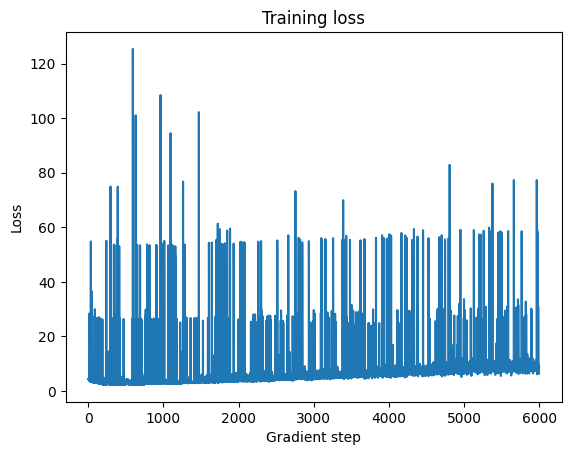

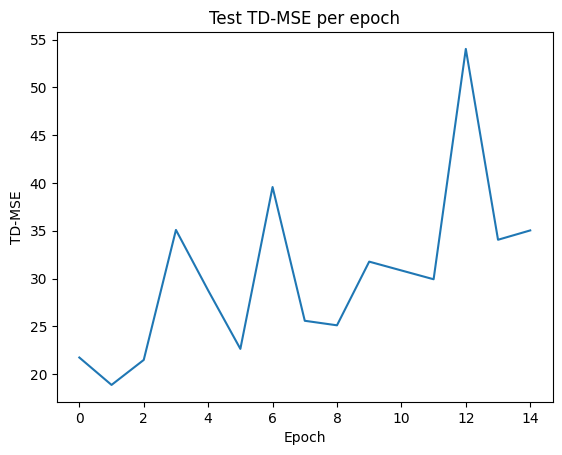

01 | peep_t=5.95 | dp_dyn=24.05 | map_median=91.0 | recommended ΔPEEP=-3.00
02 | peep_t=5.00 | dp_dyn=11.00 | map_median=78.0 | recommended ΔPEEP=-3.00
03 | peep_t=8.00 | dp_dyn=12.00 | map_median=74.0 | recommended ΔPEEP=-3.00
04 | peep_t=6.00 | dp_dyn=26.00 | map_median=64.0 | recommended ΔPEEP=-3.00
05 | peep_t=4.80 | dp_dyn=35.20 | map_median=82.0 | recommended ΔPEEP=-3.00
06 | peep_t=5.00 | dp_dyn=10.00 | map_median=99.0 | recommended ΔPEEP=-3.00
07 | peep_t=4.90 | dp_dyn=35.10 | map_median=91.0 | recommended ΔPEEP=-3.00
08 | peep_t=5.00 | dp_dyn=12.00 | map_median=63.0 | recommended ΔPEEP=-3.00


/Users/aryanb/aryan personal/code/datathon26/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/aryanb/aryan personal/code/datathon26/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/aryanb/aryan personal/code/datathon26/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/aryanb/aryan personal/code/datathon26/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/aryanb/aryan personal/code/datathon26/.venv/lib/python3.13/site-packages/

In [9]:

# =========================
# Cell 8 — Plots + quick action recommendations
# =========================
plt.figure()
plt.plot(train_losses)
plt.title("Training loss")
plt.xlabel("Gradient step")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(test_td)
plt.title("Test TD-MSE per epoch")
plt.xlabel("Epoch")
plt.ylabel("TD-MSE")
plt.show()

# Reload artifacts for inference
scaler = joblib.load(os.path.join(OUT_DIR, "scaler.joblib"))
q_eval = QNet(obs_dim, N_ACTIONS).to(DEVICE)
q_eval.load_state_dict(torch.load(os.path.join(OUT_DIR, "qnet.pt"), map_location=DEVICE))
q_eval.eval()

def recommend_delta_peep_from_row(row_like: pd.Series):
    x = np.array([[float(row_like[c]) for c in obs_cols]], dtype=np.float32)
    x_sc = scaler.transform(x)
    with torch.no_grad():
        qvals = q_eval(torch.tensor(x_sc, dtype=torch.float32).to(DEVICE)).cpu().numpy().ravel()
    a_idx = int(np.argmax(qvals))
    return float(ACTION_VALUES[a_idx]), qvals

sample = rl.sample(8, random_state=SEED)
for i, (_, r) in enumerate(sample.iterrows(), 1):
    delta, _ = recommend_delta_peep_from_row(r)
    print(f"{i:02d} | peep_t={r['peep_t']:.2f} | dp_dyn={r['dp_dyn']:.2f} | map_median={r.get('map_median', np.nan)} | recommended ΔPEEP={delta:+.2f}")
